# Import and Setup

In [87]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
import numpy as np
from numpy import array
import pandas as pd

In [88]:
from NLP_Natural_Disasters.data import get_data, clean_data

In [111]:
df = clean_data(get_data())
df

,id,text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la canada,1
2,5,resident asked shelter place officer evacuatio...,1
3,6,people receive wildfire evacuation order calif...,1
4,7,got sent photo alaska smoke wildfire school,1
...,...,...,...
7608,10869,two giant crane holding bridge collapse nearby...,1
7609,10870,control wild fire california even northern par...,1
7610,10871,utckm volcano hawaii,1
7611,10872,police investigating ebike collided car little...,1


# Embedding

In [112]:
X = df['text']
y = df['target']

In [113]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index)
vocab_size

5573

In [114]:
max_length = 20
X_token = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_token, dtype='float32', padding='post', maxlen=max_length)

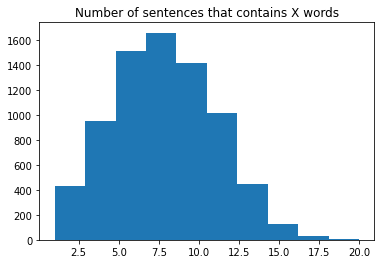

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Number of sentences that contains X words')
    plt.show()
    
plot_hist(X_token)

# TF2.0 and Keras Model Building

In [116]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, random_state=42, test_size= 0.2, stratify = y)
vec_size = 200

In [135]:
model = Sequential()

model.add(Embedding(
    input_dim=vocab_size+1,
    input_length=max_length,
    output_dim=vec_size,
    mask_zero=True
))

model.add(Conv1D(64, 8, activation ='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['acc',f1_m,precision_m, recall_m])

es = EarlyStopping(patience=5)
history = model.fit(
    X_train, 
    y_train, 
    validation_split=0.3, 
    batch_size=16, 
    epochs=100, 
    callbacks=[es], 
    validation_data = (X_test, y_test)
)

Epoch 1/100
267/267 [==============================] - 4s 11ms/step - loss: 0.6881 - acc: 0.5539 - f1_m: 0.3055 - precision_m: 0.4374 - recall_m: 0.3225 - val_loss: 0.6844 - val_acc: 0.5666 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
267/267 [==============================] - 3s 10ms/step - loss: 0.6779 - acc: 0.5758 - f1_m: 0.0460 - precision_m: 0.1667 - recall_m: 0.0272 - val_loss: 0.6821 - val_acc: 0.5677 - val_f1_m: 0.0047 - val_precision_m: 0.0174 - val_recall_m: 0.0027
Epoch 3/100
267/267 [==============================] - 3s 10ms/step - loss: 0.6699 - acc: 0.6007 - f1_m: 0.1955 - precision_m: 0.4942 - recall_m: 0.1308 - val_loss: 0.6694 - val_acc: 0.5890 - val_f1_m: 0.0854 - val_precision_m: 0.2957 - val_recall_m: 0.0512
Epoch 4/100
267/267 [==============================] - 3s 10ms/step - loss: 0.6333 - acc: 0.6810 - f1_m: 0.4953 - precision_m: 0.7181 - recall_m: 0.4114 - val_loss: 0.6225 - val_acc: 0.7425 - val_f1_m: 0.5839 - val

In [136]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test)

48/48 [==============================] - 0s 2ms/step - loss: 0.5687 - acc: 0.7666 - f1_m: 0.7287 - precision_m: 0.7180 - recall_m: 0.7559


In [137]:
f1_score

0.7286819815635681

In [138]:
precision

0.718026340007782

In [139]:
accuracy

0.7666009068489075

In [140]:
test = [
    "Truck driver lost control vehicule", 
    "It's a nice day today", 
    "Volcano erupting island", 
    "Earthquake magnitude east coast"
]
test_tk = tokenizer.texts_to_sequences(test)
test_pad = pad_sequences(test_tk, dtype='float32', padding='post', maxlen=max_length)
test_pad

array([[ 149.,  764.,  632.,  707.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [1086.,   19.,   56.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [ 441.,  273.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [ 153.,  737.,  985.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]], dtype=float32)

In [141]:
model.predict(test_pad)

array([[0.9394452 ],
       [0.20882004],
       [0.23833847],
       [0.9549391 ]], dtype=float32)